<a href="https://colab.research.google.com/github/szknbyk/-DataAnalysis/blob/main/pytorch_with_gpu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install torch torchvision

In [ ]:
# !pip install scikit-learn

In [ ]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X / 255
y = [float(s) for s in y]

In [ ]:
X.shape

(70000, 784)

3


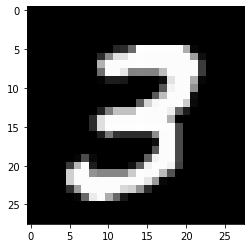

In [ ]:
# 学習データの表示例

plt.imshow(X[7].reshape(28,28), cmap=plt.cm.gray)
print("{:.0f}".format(y[7]))

In [ ]:
# 2. DataLoader作成

from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/7, random_state=0)

print(type(y_train[0]))

X_train = torch.Tensor(X_train)
X_test = torch.Tensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

ds_train = TensorDataset(X_train, y_train)
ds_test = TensorDataset(X_test, y_test)

loader_train = DataLoader(ds_train, batch_size=70, shuffle=True)
loader_test = DataLoader(ds_test, batch_size=70, shuffle=False)

<class 'float'>


In [ ]:
# # 3. ネットワーク構築

# from torch import nn

# model = nn.Sequential()
# model.add_module('fc1', nn.Linear(28*28*1, 100))
# model.add_module('relu1', nn.ReLU())
# model.add_module('fc2', nn.Linear(100, 100))
# model.add_module('relu2', nn.ReLU())
# model.add_module('fc3', nn.Linear(100, 10))

# model.to(device)
# print(model)

In [ ]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1,
                               out_channels=16,
                               kernel_size=3,
                               stride=1,
                               padding=1)
        
        self.conv2 = nn.Conv2d(in_channels=16,
                               out_channels=32,
                               kernel_size=3,
                               stride=1,
                               padding=1)
        
        self.conv3 = nn.Conv2d(in_channels=32,
                               out_channels=64,
                               kernel_size=3,
                               stride=1,
                               padding=1)
        
        self.bn1 = nn.BatchNorm2d(num_features=16)
        self.bn2 = nn.BatchNorm2d(num_features=32)
        self.bn3 = nn.BatchNorm2d(num_features=64)

        self.fc1 = nn.Linear(64 * 28 * 28, 10)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = x.view(-1, 64 * 28 * 28)
        x = self.fc1(x)
        return x


model = Model()
model.to(device)
print(model)

Model(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=50176, out_features=10, bias=True)
)


In [ ]:
# 4. 誤差関数と最適化手法の設定

from torch import optim

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [ ]:
# 5. 学習の設定

def train(epoch):
  model.train()
  correct = 0

  for data, targets in loader_train:
    data, targets = data.to(device), targets.to(device)

    data = data.reshape((-1, 1, 28, 28))

    optimizer.zero_grad()
    outputs = model(data)
    loss = loss_fn(outputs, targets)

    loss.backward()
    optimizer.step()

    _, predicted = torch.max(outputs.data, 1)
    correct += predicted.eq(targets.data.view_as(predicted)).sum()

  data_num = len(loader_train.dataset)
  print('\n訓練データの正解率：{}/{}({:.0f}%)\n'.format(correct, data_num, 100. * correct /data_num))

  print("epoch{}:終了\n".format(epoch))

In [ ]:
# 6. 推論の設定

def test():
  model.eval()
  correct = 0

  with torch.no_grad():
    for data, targets in loader_test:
      data, targets = data.to(device), targets.to(device)

      data = data.reshape((-1, 1, 28, 28))

      outputs = model(data)

      _, predicted = torch.max(outputs.data, 1)
      correct += predicted.eq(targets.data.view_as(predicted)).sum()

  data_num = len(loader_test.dataset)
  print('\nテストデータの正解率：{}/{}({:.0f}%)\n'.format(correct, data_num, 100. * correct /data_num))

In [ ]:
# 学習前のテストデータ正解率

test()


テストデータの正解率：952/10000(10%)



In [ ]:
# 7. 学習後のテストデータ正解率

for epoch in range(20):
  train(epoch)
  test()


訓練データの正解率：56966/60000(95%)

epoch0:終了


テストデータの正解率：9755/10000(98%)


訓練データの正解率：59025/60000(98%)

epoch1:終了


テストデータの正解率：9800/10000(98%)


訓練データの正解率：59196/60000(99%)

epoch2:終了


テストデータの正解率：9750/10000(98%)


訓練データの正解率：59224/60000(99%)

epoch3:終了


テストデータの正解率：9760/10000(98%)


訓練データの正解率：59243/60000(99%)

epoch4:終了


テストデータの正解率：9788/10000(98%)


訓練データの正解率：59249/60000(99%)

epoch5:終了


テストデータの正解率：9739/10000(97%)


訓練データの正解率：59305/60000(99%)

epoch6:終了


テストデータの正解率：9671/10000(97%)


訓練データの正解率：59441/60000(99%)

epoch7:終了


テストデータの正解率：9821/10000(98%)


訓練データの正解率：59320/60000(99%)

epoch8:終了


テストデータの正解率：9800/10000(98%)


訓練データの正解率：59513/60000(99%)

epoch9:終了


テストデータの正解率：9845/10000(98%)


訓練データの正解率：59603/60000(99%)

epoch10:終了


テストデータの正解率：9842/10000(98%)


訓練データの正解率：59636/60000(99%)

epoch11:終了


テストデータの正解率：9854/10000(99%)


訓練データの正解率：59648/60000(99%)

epoch12:終了


テストデータの正解率：9842/10000(98%)


訓練データの正解率：59661/60000(99%)

epoch13:終了


テストデータの正解率：9857/10000(99%)


訓練データの正解率：59727/60000(100%)



予測結果はtensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
この画像データの正解ラベルは4です


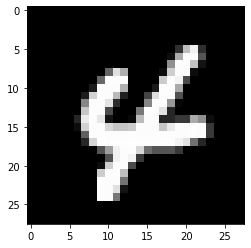

In [ ]:
# 8. 2019番目データの予測と正解結果の確認

import numpy as np

# index = 2019
index = np.random.randint(0, 10000)

model.eval()
data = X_test[index]

data = data.reshape(-1, 1, 28, 28)

data = data.to(device)
output = model(data)
_, predicted = torch.max(output.data, 0)

print("予測結果は{}".format(predicted))

X_test_show = (X_test[index]).numpy()
plt.imshow(X_test_show.reshape(28, 28), cmap='gray')
print("この画像データの正解ラベルは{:.0f}です".format(y_test[index]))

In [ ]:
# 利用した PyTorch のバージョン

print(torch.__version__)

1.7.0+cu101
